In [1]:
#how many matches we perform for each member of treatment group
HOW_MANY = 3

import os 
import json 

REDDITOR_FILE = "raw_data/redditor_dict.json"
SUBMISSION_FILE = "raw_data/submission_dict.json"
COMMENT_FILE = "raw_data/comment_dict.json"

def save_get_json(file_name):
    if (os.path.exists(file_name)):
        with open(file_name, 'r') as f:
            return json.load(f)
    return dict()


redditor_dict = save_get_json(REDDITOR_FILE)
submission_dict = save_get_json(SUBMISSION_FILE)
comment_dict = save_get_json(COMMENT_FILE)

In [4]:
#16s for O(r+s+c) operation (oof)
from datetime import datetime
CONTROL_DATE = datetime(2023,11,22)
treatment_group = ['MoosieGoose', 'JollyK9', 'Southern_Ad3032', 'bduwowy272habbw', 'Late_Introduction203', 'kapster68', 'TheApertureMonkey', 'talemoon22', 'sebagolindenwald', 'spicyranchplzz', 'TheFloorMayBeLava_02', 'rxtten_flesh', 'greenblooded395', 'greenblooded395', 'DrakenJosh98', 'WhichUsernameIsBest', 'FStahp2', 'Pongpianskul', 'Kanashimi515', 'eviuwu', 'Kattheloner_22', 'Reeze2911', 'Sac20000', 'RanpoWasTaken', 'jlynny1811', 'Playful-Fail4778', 'GarageOk8109', 'katandcats', 'holyredemption', 'jifpeanutbutter420', 'Timely_Inflation1000', 'Erica_Peanut']



#okay, we need to do feature extraction based on this 
#consider that prof wanted some kind of classification flow over the last 4 months, first stat
#online it was at least 2 weeks but we'll still do 4 months
FIRST_CONSIDER_DATE = datetime(2023, 11-3,22)


In [ ]:
#define input text model (as will be analyzed) here
from empath import Empath

global lexicon

lexicon = Empath()

#negative
lexicon.create_category("angry", ["angry"], model="nytimes")
lexicon.create_category("lonely", ["lonely"], model="nytimes")
lexicon.create_category("sad", ["sad"], model="nytimes")
lexicon.create_category("worried", ["worried"], model="nytimes")
lexicon.create_category("frustrated", ["frustrated"], model="nytimes")
lexicon.create_category("anxious", ["anxious"], model="nytimes")
lexicon.create_category("nervous", ["nervous"], model="nytimes")
lexicon.create_category("disappointed", ["disappointed"], model="nytimes")
lexicon.create_category("gloomy", ["gloomy"], model="nytimes")
lexicon.create_category("miserable", ["miserable"], model="nytimes")
lexicon.create_category("lonely", ["lonely"], model="nytimes")

#positive
lexicon.create_category("happy", ["happy"], model="nytimes")
lexicon.create_category("loved", ["loved"], model="nytimes")
lexicon.create_category("joyful", ["joyful"], model="nytimes")
lexicon.create_category("content", ["content"], model="nytimes")
lexicon.create_category("pleased", ["pleased"], model="nytimes")
lexicon.create_category("grateful", ["grateful"], model="nytimes")
lexicon.create_category("relieved", ["relieved"], model="nytimes")
lexicon.create_category("optimistic", ["optimistic"], model="nytimes")
lexicon.create_category("satisfied", ["satisfied"], model="nytimes")
lexicon.create_category("excited", ["excited"], model="nytimes")
lexicon.create_category("loved", ["loved"], model="nytimes")





In [6]:
def get_data_from_txt(txt:str):
    global lexicon

    if (not len(txt)):
        return {k: 0 for k in["angry","sad","worried",
       "frustrated","anxious",
        "nervous","disappointed",
      "gloomy","miserable","longly",
       "happy", "loved", "joyful",
        "content", "pleased",
      "grateful", "relieved",
      "optimistic", "satisfied",
        "excited"]}

    unnormalized = lexicon.analyze(txt, categories=["angry","sad","worried",
       "frustrated","anxious",
        "nervous","disappointed",
      "gloomy","miserable","longly",
       "happy", "loved", "joyful",
        "content", "pleased",
      "grateful", "relieved",
      "optimistic", "satisfied",
        "excited"],normalize = False)
  
    normalized = lexicon.analyze(txt, categories=["angry","sad","worried",
       "frustrated","anxious",
        "nervous","disappointed",
      "gloomy","miserable","longly",
       "happy", "loved", "joyful",
        "content", "pleased",
      "grateful", "relieved",
      "optimistic", "satisfied",
        "excited"],normalize = True)
    

    #we want to make these average to 0 
    summed = 0
    for v in normalized.values(): summed += v 
    to_add = -summed/len(normalized)

    for k in normalized.keys():
        normalized[k] += to_add
    
    return normalized

global txt_keys
txt_keys = ["angry","sad","worried",
       "frustrated","anxious",
        "nervous","disappointed",
      "gloomy","miserable","longly",
       "happy", "loved", "joyful",
        "content", "pleased",
      "grateful", "relieved",
      "optimistic", "satisfied",
        "excited"]

global submission_keys_order
submission_keys_order = [
        # "distinguished" ,
        "is_original_content" ,
        "over_18" ,
        "score" ,
        "title",
        "upvote_ratio" ]

global comment_key_order
comment_key_order =  [
      "is_edited",
      "num_replies", 
      "score",
      "score_is_hidden",
      "total_awards",
      "num_ups",
      "num_downs",
      "body",
      "is_submitter", 
      "stickied"
]

In [7]:
import numpy as np
import time
# import binary_search

class Redditor:
    """this is basically a class that created a data array and column label array so we can use that for KD Tree and/or Propensity Score"""

    comment_keys = []
    sub_data_keys = []

    def get_comment_data(self, comment_dict, comment_data):
        sub_id = comment_data["submission_id"] 
        comment_key = sub_id + "--------" + comment_data["comment_id"]
        try:
            comment_data_dict = comment_dict[comment_key]["data"]
        except:
            return None

        #getting comment data 
        comment_body_data = get_data_from_txt(comment_data_dict["body"])
        comment_data = [comment_data_dict[k] for k in comment_key_order]

        #make comment keys if they don't alr exist
        if (not len(Redditor.comment_keys)): Redditor.comment_keys = [comment_key_order[i] for i in range(len(comment_key_order)) if not isinstance(comment_data[i], type(""))] + [f'comment_body_{t}' for t in txt_keys]
        
        #concat numeric data and txt data
        comment_data = [v for v in comment_data if not isinstance(v, type(""))] + [comment_body_data[i] for i in txt_keys]
        return comment_data, comment_data_dict

    def get_submission_data(self, submission_dict, comment_data):
        global txt_keys
        global submission_keys_order
        global comment_key_order

        sub_id = comment_data["submission_id"] 

        #getting submission data 
        try:
            sub_data_dict = submission_dict[sub_id]
        except:
            return None 
        
        sub_data = [sub_data_dict[k] for k in submission_keys_order]

        #TODO - make lookup to avoid repeated computation
        sub_title_data = get_data_from_txt(sub_data_dict["title"])

        sub_data = [v for v in sub_data if not isinstance(v, type(""))] + [sub_title_data[i] for i in txt_keys] 

        if (not len(Redditor.sub_data_keys)): Redditor.sub_data_keys = [submission_keys_order[i] for i in range(len(submission_keys_order)) if not isinstance(sub_data[i], type(""))] + [f'submission_body_{t}' for t in txt_keys]
        return sub_data, sub_data_dict


    def __init__(self, redditor_dict, comment_dict, submission_dict, redditor_name, start_date, control_date):
        """im lazy rn so first one passed in must have at least some comments"""
        global txt_keys
        global submission_keys_order
        global comment_key_order

        self.all_data = None
        self.all_data_keys = None

        self.next_comment = None
        self.next_sub = None
        
        #yield stats related to this
        redditor =  redditor_dict[redditor_name] 
        base_redditor_data = redditor["data"]
        if (not base_redditor_data["has_subreddit"]):
            #set values to -1
            base_redditor_data["over_18"] = -1#redditor.subreddit["over_18"]
            base_redditor_data["num_subscribers"] = -1#redditor.subreddit["subscribers"]

            #this is the only one added that rlly shouldn't be
            base_redditor_data["public_description"] = ""

        
        description_data = get_data_from_txt(base_redditor_data["public_description"])

        _keys = list(base_redditor_data.keys())
        _keys.sort()

        base_data = list()
        base_data_keys = list()
        for k in _keys:
            v = base_redditor_data[k]
            if (isinstance(v, type(""))): continue
            base_data.append(v)
            base_data_keys.append(k)

        base_data += [description_data[i] for i in txt_keys] #= [v for k,v in base_redditor_data.items() if not isinstance(v, type(""))] +
        base_data_keys += [f'public_description_{i}' for i in txt_keys]

        #get sequential data for comments
        sequential_redditor_data = redditor["comments"]

        
        #sequential data -> 2 sorts
        k_segs = 2
        segments = [start_date + (1+i)*(control_date-start_date)/k_segs for i in range(k_segs)]
        cnts = [0 for _ in range(k_segs)]
        suicide_cnts = [0 for _ in range(k_segs)]
        segment_data = [np.zeros((53,),dtype='float') for _ in range(k_segs)]
        comment_keys = [] #None, just setting each time even tho inefficient
        sub_data_keys = []
        current_seg_idx = 0 

        try:
            sequential_redditor_data.sort()
        except:
            print("sequential data is ", sequential_redditor_data) #okay they have the exact same time which is why there are problems bc its not letting me sort bc dict not comparable
            return #TODO - I actually need to correct this one - this doesn't enforce types we wanted to 
        
        #we need to make sure we have data covering for all this time NOTE must add this
        is_valid = sequential_redditor_data[-1][0] < start_date if len(sequential_redditor_data) else True

        for comment_date, comment_data in sequential_redditor_data:

            #can do binary search for efficiency in future - TODO
            if (comment_date > control_date):
                
                #get data from comment
                returned_comment = self.get_comment_data(comment_dict, comment_data)
                if (isinstance(returned_comment, type(None))):
                    return
                comment_data, comment_data_dict = returned_comment

                #get data from submission
                returned_sub = self.get_submission_data(submission_dict,comment_data)
                if (isinstance(returned_sub, type(None))):
                    return
                sub_data, sub_data_dict = returned_sub

                assert(len(Redditor.comment_keys) == len(comment_data))
                self.next_comment = {Redditor.sub_data_keys[i] : comment_data[i] for i in range(len(comment_data))} 

                assert(len(Redditor.sub_data_keys) == len(comment_data))
                self.next_sub = {Redditor.sub_data_keys[i] : sub_data[i] for i in range(len(sub_data))}

                #going to make predicted be the level of sadness of next comment
                self.y = np.mean(self.next_comment[f'comment_body_{i}'] for i in ["angry","sad","worried","frustrated","anxious","nervous","disappointed","gloomy","miserable","longly"])
                
                break 
            if (comment_date < start_date): continue 

            #get data from comment
            returned_comment = self.get_comment_data(comment_dict, comment_data)
            if (isinstance(returned_comment, type(None))):
                return
            comment_data, comment_data_dict = returned_comment

            #get data from submission
            returned_sub = self.get_submission_data(submission_dict,comment_data)
            if (isinstance(returned_sub, type(None))):
                return
            sub_data, sub_data_dict = returned_sub

            #aggregate
            all_time_info = np.array(comment_data + sub_data, dtype='float')

            #advance thru segments
            while (segments[current_seg_idx] < comment_date):
                current_seg_idx += 1
            
            cnts[current_seg_idx] += 1

            segment_data[current_seg_idx] += all_time_info

            if (any(kw in sub_data_dict["title"] for kw in ["suicide", "depress"]) or any(kw in comment_data_dict["body"] for kw in ["suicide", "depress"])):
                suicide_cnts[current_seg_idx] += 1


        #make my segment keys 
        segment_keys = ["comment_"+ i for i in Redditor.comment_keys] + ["submission_" + i for i in Redditor.sub_data_keys ]

        all_data = base_data*1
        all_data_keys = base_data_keys * 1

        #check lengths match up
        assert len(all_data) == len(all_data_keys), "(0) all_data is of len " + str(len(all_data)) + " all data keys is of len " + str(len(all_data_keys))
        assert len(segment_keys) == len(segment_data[0].tolist()), "segment keys is len " + str(len(segment_keys)) + " while segment_data is len " +  str(len(segment_data[0].tolist()))
        
        
        #add segment data in 
        segment_data = [segment_data[i]/max(1,cnts[i]) for i in range(k_segs)]
        for i in range(k_segs):
            all_data += segment_data[i].tolist()
            all_data_keys += [f'seg_{i}_{key_name}' for key_name in segment_keys]

        for i in range(1): 
            all_data.append(is_valid)
            all_data_keys.append("is_valid")
        for i in range(1): 
            all_data += cnts
            all_data_keys += [f'num_comments_in_seg_{i}' for i in range(len(cnts))]
        for i in range(1):
            all_data += suicide_cnts
            all_data_keys += [f'num_suicide_mentions_{i}' for i in range(len(suicide_cnts))]

        assert len(all_data) == len(all_data_keys), "all_data is of len " + str(len(all_data)) + " all data keys is of len " + str(len(all_data_keys))
        self.all_data_keys = all_data_keys
        self.all_data = np.array(all_data, dtype='float')
            #add it to the correct one 


        #okay time to get sequential data
        


    def get_data(self):
        return self.all_data
    
Redditor(redditor_dict, comment_dict, submission_dict, treatment_group[0], int(time.mktime(FIRST_CONSIDER_DATE.timetuple())), int(time.mktime(CONTROL_DATE.timetuple())) )
# redditor_dict = save_get_json(REDDITOR_FILE)
# submission_dict = save_get_json(SUBMISSION_FILE)
# comment_dict = save_get_json(COMMENT_FILE)

# Make Control/Treat Data

In [168]:
query_redditors = np.array([Redditor(redditor_dict, comment_dict, submission_dict, t, int(time.mktime(FIRST_CONSIDER_DATE.timetuple())), int(time.mktime(CONTROL_DATE.timetuple())) ).get_data() for t in treatment_group])

In [169]:
from tqdm import tqdm
control_keys  = [c for c in redditor_dict.keys() if not c in treatment_group]
control_redditors = list()

#TODO - parallelize
for c in tqdm(control_keys):
    control_redditors.append(Redditor(redditor_dict, comment_dict, submission_dict, c, int(time.mktime(FIRST_CONSIDER_DATE.timetuple())), int(time.mktime(CONTROL_DATE.timetuple()))))

  0%|          | 0/13207 [00:00<?, ?it/s]

  5%|▍         | 596/13207 [00:16<07:24, 28.39it/s]

sequential data is  [[1701464078, {'subreddit_id': 't5_2s30g', 'submission_id': '188m65r', 'comment_id': 'kbliupi'}], [1701464077, {'subreddit_id': 't5_2vfcm', 'submission_id': '188m663', 'comment_id': 'kbliuoh'}], [1701464077, {'subreddit_id': 't5_8pn3m2', 'submission_id': '188m65w', 'comment_id': 'kbliumv'}], [1701464077, {'subreddit_id': 't5_h4uwp', 'submission_id': '188m65k', 'comment_id': 'kbliumc'}], [1701464077, {'subreddit_id': 't5_34jka', 'submission_id': '188m64j', 'comment_id': 'kblium2'}], [1701464077, {'subreddit_id': 't5_2vgi4', 'submission_id': '188m65n', 'comment_id': 'kbliulv'}], [1701464077, {'subreddit_id': 't5_5t8ubq', 'submission_id': '188m65o', 'comment_id': 'kbliulx'}], [1701464077, {'subreddit_id': 't5_8pn3m2', 'submission_id': '188m65q', 'comment_id': 'kbliulg'}], [1701464077, {'subreddit_id': 't5_2rpd0', 'submission_id': '188m651', 'comment_id': 'kbliul1'}], [1701464076, {'subreddit_id': 't5_8pn3m2', 'submission_id': '188m65h', 'comment_id': 'kbliuk9'}], [1701

  5%|▍         | 600/13207 [00:17<07:26, 28.25it/s]

sequential data is  [[1635148677, {'subreddit_id': 't5_2seh9', 'submission_id': 'qel8rv', 'comment_id': 'hhyng5p'}], [1635148629, {'subreddit_id': 't5_2s30g', 'submission_id': 'qeudzb', 'comment_id': 'hhyne8w'}], [1635148621, {'subreddit_id': 't5_2ymzc', 'submission_id': 'qfafk3', 'comment_id': 'hhyndwp'}], [1635148519, {'subreddit_id': 't5_2ubgg', 'submission_id': 'qexz8g', 'comment_id': 'hhyn9wq'}], [1635148003, {'subreddit_id': 't5_11isbz', 'submission_id': 'qf12j6', 'comment_id': 'hhymonw'}], [1635147876, {'subreddit_id': 't5_3buf1', 'submission_id': 'qf79sc', 'comment_id': 'hhymjgc'}], [1635147820, {'subreddit_id': 't5_26lae1', 'submission_id': 'qeqcde', 'comment_id': 'hhymh4j'}], [1635147710, {'subreddit_id': 't5_2s4cy', 'submission_id': 'qf68vo', 'comment_id': 'hhymcf9'}], [1635147684, {'subreddit_id': 't5_53zemd', 'submission_id': 'pyk3os', 'comment_id': 'hhymbad'}], [1635147668, {'subreddit_id': 't5_2yk91', 'submission_id': 'qezcl4', 'comment_id': 'hhymajr'}], [1635147656, {'s

 29%|██▉       | 3881/13207 [01:30<03:24, 45.55it/s]

sequential data is  [[1679520756, {'subreddit_id': 't5_2ssp7', 'submission_id': '11yblpn', 'comment_id': 'jd9uy20'}], [1674784672, {'subreddit_id': 't5_2yo6b', 'submission_id': '10lug0j', 'comment_id': 'j61nwnk'}], [1674784603, {'subreddit_id': 't5_39ne7', 'submission_id': '10m05l5', 'comment_id': 'j61nr5t'}], [1674784398, {'subreddit_id': 't5_39ne7', 'submission_id': '10jzuts', 'comment_id': 'j61nask'}], [1673985200, {'subreddit_id': 't5_2ssp7', 'submission_id': '10dxmif', 'comment_id': 'j4rlt8n'}], [1673321029, {'subreddit_id': 't5_msyp9', 'submission_id': '107wsln', 'comment_id': 'j3pbu28'}], [1672939447, {'subreddit_id': 't5_39ne7', 'submission_id': '103wu4v', 'comment_id': 'j32ok91'}], [1672936001, {'subreddit_id': 't5_swxxz', 'submission_id': '103ymoh', 'comment_id': 'j32f4hm'}], [1672886413, {'subreddit_id': 't5_39em5', 'submission_id': '103ctml', 'comment_id': 'j2zyj1c'}], [1672859586, {'subreddit_id': 't5_2ssp7', 'submission_id': '103494k', 'comment_id': 'j2y15m1'}], [16728516

 30%|██▉       | 3900/13207 [01:30<04:07, 37.58it/s]

sequential data is  [[1592773467, {'subreddit_id': 't5_swm44', 'submission_id': 'frqfg3', 'comment_id': 'fvknflh'}], [1592772688, {'subreddit_id': 't5_2xhvq', 'submission_id': 'hd72ld', 'comment_id': 'fvkm111'}], [1592767354, {'subreddit_id': 't5_2xhvq', 'submission_id': 'hd72ld', 'comment_id': 'fvkcbgu'}], [1592767354, {'subreddit_id': 't5_2xhvq', 'submission_id': 'hd72ld', 'comment_id': 'fvkcbgq'}], [1592762213, {'subreddit_id': 't5_2xhvq', 'submission_id': 'hd72ld', 'comment_id': 'fvk2qz7'}], [1592761310, {'subreddit_id': 't5_3jj03', 'submission_id': 'hd3tak', 'comment_id': 'fvk135f'}], [1592700798, {'subreddit_id': 't5_m0bnr', 'submission_id': 'hcrfr4', 'comment_id': 'fvhs67i'}], [1592680782, {'subreddit_id': 't5_2sdqx', 'submission_id': 'hcp9q0', 'comment_id': 'fvgtaug'}], [1592618128, {'subreddit_id': 't5_2uao3', 'submission_id': 'hcb0rn', 'comment_id': 'fvef1cd'}], [1592343849, {'subreddit_id': 't5_3079s', 'submission_id': 'h9x0pa', 'comment_id': 'fv24gdj'}], [1592323454, {'subr

 51%|█████▏    | 6801/13207 [02:43<03:22, 31.65it/s]

sequential data is  [[1514783713, {'subreddit_id': 't5_2qiel', 'submission_id': '7mwmd9', 'comment_id': 'ds0zj3e'}], [1514619948, {'subreddit_id': 't5_35fmc', 'submission_id': '7mn35n', 'comment_id': 'dry2kgn'}], [1514614038, {'subreddit_id': 't5_2qiel', 'submission_id': '7mwmd9', 'comment_id': 'drxzplm'}], [1514491261, {'subreddit_id': 't5_2qh1u', 'submission_id': '7mkqmx', 'comment_id': 'drvjquy'}], [1513752458, {'subreddit_id': 't5_2t2gv', 'submission_id': '7kk7gs', 'comment_id': 'driegdf'}], [1513053891, {'subreddit_id': 't5_2tgev', 'submission_id': '7h14rg', 'comment_id': 'dr4en9w'}], [1512630321, {'subreddit_id': 't5_2cneq', 'submission_id': '7i4f36', 'comment_id': 'dqw3op6'}], [1511331884, {'subreddit_id': 't5_2qh68', 'submission_id': '7eebzm', 'comment_id': 'dq6h1a8'}], [1511246172, {'subreddit_id': 't5_2qh68', 'submission_id': '7eebzm', 'comment_id': 'dq4pmd4'}], [1511114959, {'subreddit_id': 't5_2qh68', 'submission_id': '7dyrv5', 'comment_id': 'dq1vzlz'}], [1510772010, {'subr

 55%|█████▌    | 7292/13207 [02:54<01:47, 54.95it/s]

sequential data is  [[1701867795, {'subreddit_id': 't5_9fpi8f', 'submission_id': '18bymly', 'comment_id': 'kc7zvmv'}], [1701862456, {'subreddit_id': 't5_2qjpg', 'submission_id': '18bzc8e', 'comment_id': 'kc7r5d5'}], [1701862245, {'subreddit_id': 't5_2s8z6', 'submission_id': '18c1e6x', 'comment_id': 'kc7quu3'}], [1701836685, {'subreddit_id': 't5_2qhjv', 'submission_id': '18bt79f', 'comment_id': 'kc6rsks'}], [1701830552, {'subreddit_id': 't5_2qhjv', 'submission_id': '18bt79f', 'comment_id': 'kc6egko'}], [1701824229, {'subreddit_id': 't5_2qh44', 'submission_id': '18b62bv', 'comment_id': 'kc6061m'}], [1701822228, {'subreddit_id': 't5_2qh44', 'submission_id': '18b62bv', 'comment_id': 'kc5vmd8'}], [1701821961, {'subreddit_id': 't5_2qh44', 'submission_id': '18b62bv', 'comment_id': 'kc5v0ok'}], [1701810158, {'subreddit_id': 't5_2qh44', 'submission_id': '18b62bv', 'comment_id': 'kc525si'}], [1701810012, {'subreddit_id': 't5_2qh44', 'submission_id': '18b62bv', 'comment_id': 'kc51qyu'}], [1701802

 71%|███████   | 9344/13207 [03:36<01:16, 50.80it/s]

sequential data is  [[1701911553, {'subreddit_id': 't5_2xhvq', 'submission_id': '18cjda0', 'comment_id': 'kcb299w'}], [1701911520, {'subreddit_id': 't5_2xhvq', 'submission_id': '18cjhjw', 'comment_id': 'kcb26kt'}], [1701909868, {'subreddit_id': 't5_2xhvq', 'submission_id': '18cihbe', 'comment_id': 'kcayd5r'}], [1701909594, {'subreddit_id': 't5_2xhvq', 'submission_id': '18cirlc', 'comment_id': 'kcaxqnl'}], [1701909555, {'subreddit_id': 't5_2xhvq', 'submission_id': '18cismf', 'comment_id': 'kcaxnjd'}], [1701909422, {'subreddit_id': 't5_2xhvq', 'submission_id': '18civ7m', 'comment_id': 'kcaxclh'}], [1701908680, {'subreddit_id': 't5_2xhvq', 'submission_id': '18cik2v', 'comment_id': 'kcavm51'}], [1701908488, {'subreddit_id': 't5_2xhvq', 'submission_id': '18c28ge', 'comment_id': 'kcav5ux'}], [1701908451, {'subreddit_id': 't5_2xhvq', 'submission_id': '18aru17', 'comment_id': 'kcav2q8'}], [1701908420, {'subreddit_id': 't5_2xhvq', 'submission_id': '18c28ge', 'comment_id': 'kcav062'}], [17019083

 75%|███████▌  | 9913/13207 [03:47<01:01, 53.53it/s]

sequential data is  [[1701913199, {'subreddit_id': 't5_2qlmm', 'submission_id': '18by8ln', 'comment_id': 'kcb63j1'}], [1701912608, {'subreddit_id': 't5_32q13', 'submission_id': '18bz38g', 'comment_id': 'kcb4pn0'}], [1701912175, {'subreddit_id': 't5_2qlmm', 'submission_id': '18by8ln', 'comment_id': 'kcb3pbf'}], [1701912158, {'subreddit_id': 't5_2qhuq', 'submission_id': '18cbra1', 'comment_id': 'kcb3nwk'}], [1701893342, {'subreddit_id': 't5_2qqt8', 'submission_id': '18bybt3', 'comment_id': 'kc9rqvo'}], [1701893199, {'subreddit_id': 't5_2qqt8', 'submission_id': '18bybt3', 'comment_id': 'kc9rcr3'}], [1701892252, {'subreddit_id': 't5_2qlmm', 'submission_id': '18by8ln', 'comment_id': 'kc9oryu'}], [1701890796, {'subreddit_id': 't5_2qhuq', 'submission_id': '18cbra1', 'comment_id': 'kc9ktsu'}], [1701890780, {'subreddit_id': 't5_2qqt8', 'submission_id': '18bybt3', 'comment_id': 'kc9ks6s'}], [1701890625, {'subreddit_id': 't5_2qlmm', 'submission_id': '18by8ln', 'comment_id': 'kc9kd6v'}], [17018883

 96%|█████████▋| 12741/13207 [04:42<00:06, 70.24it/s]

sequential data is  [[1691578394, {'subreddit_id': 't5_2gjv82', 'submission_id': '15l44ax', 'comment_id': 'jvfc1tn'}], [1691477584, {'subreddit_id': 't5_2gjv82', 'submission_id': '15l44ax', 'comment_id': 'jv9p4d1'}], [1690888840, {'subreddit_id': 't5_2s0lb', 'submission_id': '15ekoeq', 'comment_id': 'jubu2ps'}], [1689227257, {'subreddit_id': 't5_2qh1i', 'submission_id': '14y49h7', 'comment_id': 'jrrpozr'}], [1688183704, {'subreddit_id': 't5_2r878', 'submission_id': '14n849k', 'comment_id': 'jq7ybjo'}], [1681410558, {'subreddit_id': 't5_2qh1i', 'submission_id': '12jwf4o', 'comment_id': 'jg4ksgs'}], [1679755882, {'subreddit_id': 't5_2uz4o', 'submission_id': '1212ty5', 'comment_id': 'jdmklzb'}], [1677837364, {'subreddit_id': 't5_2t6kz', 'submission_id': '11ga5g6', 'comment_id': 'jaql9w3'}], [1676478769, {'subreddit_id': 't5_2qh1i', 'submission_id': '112us2g', 'comment_id': 'j8ngazy'}], [1673828500, {'subreddit_id': 't5_3kh5d', 'submission_id': '10coxii', 'comment_id': 'j4iq019'}], [167382

100%|██████████| 13207/13207 [04:50<00:00, 45.48it/s]


In [170]:
#remove bad users from control

final_control = list()
final_control_usernames = list()
for c_index in range(len(control_redditors)):
    c = control_redditors[c_index]
    try:
        if (not isinstance(c.all_data, type(None))):
            final_control.append(c)
            final_control_usernames.append(control_keys[c_index])
    except:
        pass

## Method 1 - KD Tree

In [175]:
#kd tree
#O(k*n*log(n)) construction
#O(q*(log(n)->n)) query 

#search
#O(q*k^2 * n)

#kd
#log(n) < q*k

In [176]:
from sklearn.neighbors import KDTree

In [177]:
data = np.array([c.get_data().tolist() for c in final_control])
data = np.nan_to_num(data)

In [180]:
#recenter data based on mean/std

#okay we need to restructure data and query 
epsilon = 1/100000000
mean_data = np.mean(data, axis=0).reshape(1,-1)
std_data = np.std(data, axis=0).reshape(1,-1)

new_data =(data  - mean_data)/(std_data + epsilon)
new_query_redditors = (query_redditors  - mean_data)/(std_data + epsilon)

(13197, 311)


In [182]:
#create KD Tree
tree = KDTree(new_data)

In [217]:
dist, matched_indices = tree.query(new_query_redditors, k = HOW_MANY)

In [ ]:
list_of_control = list()
list_of_control_data = list()

all_distances = list()
treat_to_matched_control = dict()
ppl_with_matches = dict()
for dist_idx, treat_idx in enumerate(matched_indices):
    for distance, idx in zip(dist[dist_idx], treat_idx):
        #if it's too far away, break
        if (distance > 10000):
            break
        print(final_control_usernames[idx])
        # print(control_group[dist_idx])
        ppl_with_matches[treatment_group[dist_idx]] = True 

        list_of_control.append(final_control_usernames[idx])
        list_of_control_data.append(new_data[idx])
        print(distance)
        all_distances.append(distance)
        # ppl_with_matches[control_group]
        # print(new_data[idx].shape)

print("u: ", np.mean(all_distances), "sigma:", np.std(all_distances), "min:", np.min(all_distances), "max:", np.max(all_distances), "median:",np.median(all_distances))
print("ppl without matches r: ", [t for t in treatment_group if not t in ppl_with_matches])

print("ppl without matches proportion r: ", len([t for t in treatment_group if not t in ppl_with_matches])/len(treatment_group))

In [219]:
vanilla_kd_control = list_of_control

## Method 2 - Propensity Score 

In [ ]:
#https://pypi.org/project/psmpy/

In [ ]:
!pip install psmpy

In [188]:
from sklearn.decomposition import PCA
import pandas as pd

combined_data = np.concatenate((new_data, new_query_redditors))
keys = control_redditors[0].all_data_keys

In [206]:
#use psmpy for propensity score matching

control_df = pd.DataFrame(new_data)
control_df.columns = keys
control_df["unique_id"] = np.array([i for i in range(len(final_control_usernames))],dtype=float)
control_df["is_treatment"] = np.array([0 for i in range(len(final_control_usernames))],dtype=float)

control_df = control_df.loc[:,~control_df.columns.duplicated()]
# treatment_df.head()

treatment_df = pd.DataFrame(new_query_redditors)
treatment_df.columns = keys 
treatment_df["unique_id"] = np.array([len(final_control_usernames)+1+ i for i in range(len(treatment_group))],dtype=float)#control_group #again misnamed
#seperate control by treatment - id shuld have one additional space btw
treatment_df["is_treatment"] = np.array([1 for i in range(len(treatment_group))])

treatment_df = treatment_df.loc[:,~treatment_df.columns.duplicated()]


combined_df = pd.concat((treatment_df, control_df))

combined_df

,comment_karma,time_creation,verified_email,is_employee,is_mod,is_gold,is_suspended,link_karma,num_moderated,num_multireddits,...,seg_1_submission_title_optimistic,seg_1_submission_title_satisfied,seg_1_submission_title_excited,is_valid,num_comments_in_seg_0,num_comments_in_seg_1,num_suicide_mentions_0,num_suicide_mentions_1,unique_id,is_treatment
0,0.052752,-0.045274,0.318148,0.0,-0.410483,-0.109017,0.0,-0.124217,-0.034805,-0.036699,...,0.144252,0.103337,0.484973,-0.369322,-0.532442,2.282694,-0.166512,-0.224639,13198.0,1.0
1,-0.356199,0.609150,0.318148,0.0,-0.410483,-0.109017,0.0,-0.122769,-0.034805,-0.036699,...,0.343915,0.300439,0.048083,2.707663,-0.532442,-0.882631,-0.166512,-0.224639,13199.0,1.0
2,-0.349838,0.587403,-3.143189,0.0,-0.410483,-0.109017,0.0,-0.097257,-0.034805,-0.036699,...,0.343915,0.300439,0.048083,2.707663,-0.532442,-0.882631,-0.166512,-0.224639,13200.0,1.0
3,-0.363437,0.571260,-3.143189,0.0,-0.410483,-0.109017,0.0,-0.126162,-0.034805,-0.036699,...,0.343915,0.300439,0.048083,2.707663,-0.532442,-0.882631,-0.166512,-0.224639,13201.0,1.0
4,-0.364304,0.643093,0.318148,0.0,-0.410483,-0.109017,0.0,-0.130921,-0.034805,-0.036699,...,0.343915,0.300439,0.048083,2.707663,-0.532442,-0.882631,-0.166512,-0.224639,13202.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13192,2.634757,-0.942214,-3.143189,0.0,-0.410483,-0.109017,0.0,-0.056808,-0.034805,-0.036699,...,0.343915,0.300439,0.048083,-0.369322,-0.532442,-0.882631,-0.166512,-0.224639,13192.0,0.0
13193,-0.360235,-0.052152,0.318148,0.0,-0.410483,-0.109017,0.0,-0.130445,-0.034805,-0.036699,...,-0.306601,-0.341731,-0.379326,-0.369322,0.814768,-0.332140,-0.166512,-0.224639,13193.0,0.0
13194,-0.348104,-0.486863,0.318148,0.0,-0.410483,-0.109017,0.0,-0.130280,-0.034805,-0.036699,...,-1.206422,-1.230006,1.762165,-0.369322,-0.532442,0.872060,-0.166512,3.076656,13194.0,0.0
13195,-0.273839,-0.528348,0.318148,0.0,-0.410483,-0.109017,0.0,-0.130259,-0.034805,-0.036699,...,0.624914,0.577832,0.232707,-0.369322,-0.532442,0.768843,-0.166512,-0.224639,13195.0,0.0


In [207]:
from psmpy import PsmPy
import pandas.api.types as ptypes
import warnings

psm = PsmPy(combined_df, treatment = "is_treatment", indx="unique_id")

print(psm.treatmentdf.shape)
print(psm.controldf.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    psm.logistic_ps(balance = True)

(32, 144)
(13197, 144)


In [208]:
psm.knn_matched_12n(matcher='propensity_logit', how_many=HOW_MANY)

exclude_column = "unique_id"
matched_ids = psm.matched_ids
matched_ids.set_index("unique_id", inplace = True)
# result_dict = {key: df.loc[key].values.tolist() for key in df.index}

# Create a dictionary where the keys are from the 'unique_id' column and values are arrays of other columns
result_dict = {key: matched_ids.iloc[i, :].values.tolist() for i, key in enumerate(matched_ids.index)}

print(result_dict)

{13198.0: [11881.0, 1814.0, 8765.0, 12082.0], 13199.0: [4297.0, 475.0, 4887.0, 8674.0], 13200.0: [5126.0, 6722.0, 7654.0, 6714.0], 13201.0: [4172.0, 7714.0, 11353.0, 12574.0], 13202.0: [40.0, 12550.0, 4556.0, 9637.0], 13203.0: [3069.0, 11848.0, 8369.0, 2688.0], 13204.0: [3325.0, 9157.0, 11104.0, 10522.0], 13205.0: [7355.0, 8594.0, 10598.0, 9288.0], 13206.0: [4390.0, 887.0, 4124.0, 13092.0], 13207.0: [4674.0, 13123.0, 9831.0, 3604.0], 13208.0: [12059.0, 521.0, 738.0, 1276.0], 13209.0: [9504.0, 9950.0, 8279.0, 6928.0], 13210.0: [10671.0, 6738.0, 1954.0, 12892.0], 13211.0: [6876.0, 9720.0, 3766.0, 4994.0], 13212.0: [4500.0, 6496.0, 11673.0, 7511.0], 13213.0: [9549.0, 6135.0, 7410.0, 7309.0], 13214.0: [9850.0, 12514.0, 6970.0, 10095.0], 13215.0: [5352.0, 854.0, 924.0, 1552.0], 13216.0: [6441.0, 1307.0, 9017.0, 12166.0], 13217.0: [5049.0, 8574.0, 3848.0, 11513.0], 13218.0: [16.0, 9603.0, 1956.0, 4329.0], 13219.0: [10794.0, 1513.0, 8009.0, 11834.0], 13220.0: [92.0, 8214.0, 10131.0, 11780.0],

In [ ]:
#get control group based on logistic regression propensity score matching
propensity_matched_users = [final_control_usernames[int(i)] for j in result_dict.values() for i in j]
propensity_score_data = [new_data[int(i)] for j in result_dict.values() for i in j]
print(propensity_matched_users)
print(propensity_score_data)

In [210]:
#match based on PCA of higher size than two
pca = PCA(n_components=66)
pca.fit_transform(combined_data)
print(sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)

0.9291610075988217 [0.1122272  0.07198057 0.05216258 0.04365697 0.03825826 0.03460267
 0.03368466 0.03201091 0.02703575 0.02364148 0.01990669 0.01841435
 0.01762382 0.01717226 0.01703768 0.01656652 0.01634354 0.01614399
 0.01542229 0.01354754 0.01323971 0.01259406 0.0121432  0.01192617
 0.01134964 0.01048847 0.01039318 0.00997864 0.00988944 0.00959317
 0.00941113 0.00940082 0.00883687 0.00829574 0.00789695 0.00758694
 0.00700412 0.00687582 0.00680764 0.00643207 0.0063197  0.00612307
 0.00514354 0.00488684 0.00482663 0.00467286 0.00452056 0.00440187
 0.0042428  0.00402428 0.00400968 0.0038242  0.00376758 0.00367377
 0.00366301 0.00356562 0.00339722 0.0032835  0.0031848  0.00312293
 0.00299037 0.00296924 0.00288039 0.00276857 0.00268503 0.00262942]


## Propensity Score w/ PCA

In [211]:
#REPEAT propensity score w/ PCA
import random
random.seed(55)
new_data_pca = pca.transform(new_data)
query_data_pca = pca.transform(new_query_redditors)


"""COPIED FROM ABOVE - SHOULD MAKE INTO FUNCTION"""
control_df = pd.DataFrame(new_data_pca)
# control_df.columns = keys
control_df["unique_id"] = np.array([i for i in range(len(final_control_usernames))],dtype=float)
control_df["is_treatment"] = np.array([0 for i in range(len(final_control_usernames))],dtype=float)

control_df = control_df.loc[:,~control_df.columns.duplicated()]
# treatment_df.head()

treatment_df = pd.DataFrame(query_data_pca)
# treatment_df.columns = keys 
treatment_df["unique_id"] = np.array([len(final_control_usernames)+1+ i for i in range(len(treatment_group))],dtype=float)#control_group #again misnamed
#seperate control by treatment - id shuld have one additional space btw
treatment_df["is_treatment"] = np.array([1 for i in range(len(treatment_group))])

treatment_df = treatment_df.loc[:,~treatment_df.columns.duplicated()]


combined_df = pd.concat((treatment_df, control_df))

psm2 = PsmPy(combined_df, treatment = "is_treatment", indx="unique_id")

print(psm2.treatmentdf.shape)
print(psm2.controldf.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    psm2.logistic_ps(balance = True)



psm2.knn_matched_12n(matcher='propensity_logit', how_many=HOW_MANY)

exclude_column = "unique_id"
matched_ids = psm2.matched_ids
matched_ids.set_index("unique_id", inplace = True)
# result_dict = {key: df.loc[key].values.tolist() for key in df.index}

# Create a dictionary where the keys are from the 'unique_id' column and values are arrays of other columns
result_dict_pca = {key: matched_ids.iloc[i, :].values.tolist() for i, key in enumerate(matched_ids.index)}

print(result_dict_pca)

propensity_pca_matched_users = [final_control_usernames[int(i)] for j in result_dict_pca.values() for i in j]
propensity_pca_score_data = [new_data[int(i)] for j in result_dict_pca.values() for i in j]
print(propensity_pca_matched_users)


(32, 67)
(13197, 67)
{13198.0: [2914.0, 40.0, 9969.0, 594.0], 13199.0: [8214.0, 12354.0, 56.0, 3640.0], 13200.0: [2937.0, 12059.0, 2688.0, 10190.0], 13201.0: [80.0, 4630.0, 4822.0, 10904.0], 13202.0: [10867.0, 11446.0, 5485.0, 4688.0], 13203.0: [6596.0, 230.0, 1115.0, 12033.0], 13204.0: [11158.0, 7309.0, 12574.0, 4672.0], 13205.0: [10643.0, 9831.0, 2402.0, 13150.0], 13206.0: [5709.0, 7944.0, 7223.0, 12772.0], 13207.0: [6374.0, 10720.0, 4887.0, 10991.0], 13208.0: [12602.0, 4674.0, 1777.0, 5231.0], 13209.0: [10959.0, 5935.0, 10407.0, 4058.0], 13210.0: [11104.0, 12082.0, 4391.0, 7860.0], 13211.0: [3848.0, 1598.0, 290.0, 6890.0], 13212.0: [932.0, 2867.0, 10088.0, 2267.0], 13213.0: [4258.0, 5971.0, 7682.0, 4374.0], 13214.0: [374.0, 8356.0, 10930.0, 9941.0], 13215.0: [6496.0, 4031.0, 6235.0, 10265.0], 13216.0: [9157.0, 12701.0, 7106.0, 11834.0], 13217.0: [5727.0, 1463.0, 8279.0, 9504.0], 13218.0: [12550.0, 8321.0, 10696.0, 10131.0], 13219.0: [11353.0, 10619.0, 1276.0, 12683.0], 13220.0: [368

## Analyze Results

In [212]:
n_components = 2

combined_pca = PCA(n_components=2)
combined_pca.fit_transform(combined_data)
# combined_pca.fit_transform(new_query_redditors)

treat_pca = PCA(n_components=n_components)
treat_pca.fit_transform(new_query_redditors)
query_components = combined_pca.transform(new_query_redditors)
print("explained variance (treat) if PCA for just them", sum(treat_pca.explained_variance_ratio_), treat_pca.explained_variance_ratio_)


principalComponents = combined_pca.fit_transform(new_data)

pca = PCA(n_components=n_components)
pca.fit_transform(new_data)
print("explained variance (control all)", sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)


selected_control = combined_pca.transform(list_of_control_data)
trial_pca = PCA(n_components=n_components)
trial_pca.fit_transform(list_of_control_data)
print("explained variance (control KD) if PCA for just them", sum(trial_pca.explained_variance_ratio_), trial_pca.explained_variance_ratio_)

propensity_users = combined_pca.fit_transform(propensity_score_data)
trial_pca.fit_transform(propensity_score_data)
print("explained variance (propensity) if PCA for just them", sum(trial_pca.explained_variance_ratio_), trial_pca.explained_variance_ratio_)

propensity_pca_users = combined_pca.fit_transform(propensity_pca_score_data)
trial_pca.fit_transform(propensity_pca_score_data)
print("explained variance (propensity + PCA before) if PCA for just them", sum(trial_pca.explained_variance_ratio_), trial_pca.explained_variance_ratio_)


explained variance (treat) if PCA for just them 0.7755686247380504 [0.59150244 0.18406619]
explained variance (control all) 0.18406033725614843 [0.11226972 0.07179061]
explained variance (control KD) if PCA for just them 0.6618471791926948 [0.55319749 0.10864969]
explained variance (propensity) if PCA for just them 0.7285513058328565 [0.45852128 0.27003002]
explained variance (propensity + PCA before) if PCA for just them 0.6605350364905971 [0.37690451 0.28363053]


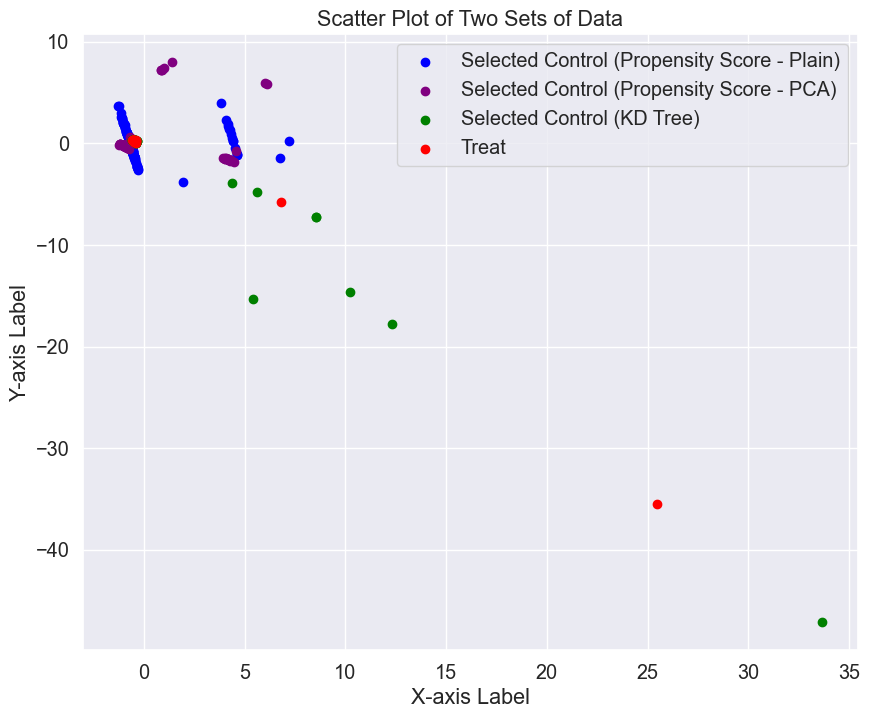

In [214]:
import matplotlib.pyplot as plt

# Extract x and y coordinates from the data
# x1, y1 = zip(*principalComponents)
x2, y2 = zip(*query_components)
x3, y3 = zip(*selected_control)
x4, y4 = zip(*propensity_users)
x5, y5 = zip(*propensity_pca_users)

# Create a scatter plot with different colors for each set
# plt.scatter(x1, y1, color='blue', label='All Other')


plt.scatter(x4, y4, color='blue', label='Selected Control (Propensity Score - Plain)')
plt.scatter(x5, y5, color='purple', label='Selected Control (Propensity Score - PCA)')
plt.scatter(x3, y3, color='green', label='Selected Control (KD Tree)')
plt.scatter(x2, y2, color='red', label='Treat')


# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot of Two Sets of Data')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [220]:
#lets get all our groups of users so we can run on other side

print("pca + propensity:",propensity_pca_matched_users )
print("propensity:",propensity_matched_users )
print("KD:",vanilla_kd_control )

pca + propensity: ['fairyoutlander', 'Secret_Criticism3437', 'DreniCake', 'jolielu', 'ShamingShoegaze', 'happy-snack', 'HollowPomegranate', 'Agitated_Metal4063', 'ValaTheSly', 'Freddybear480', 'meindawg', 'beaniebae37', 'Key-Philosophy-2877', 'SnooSuggestions3477', 'Dm_me9596', 'emmurphy234', 'a1ayy', 'Jeanfyere', 'MusicZealousideal288', 'dullivan', 'GeneralSab', 'ResponsibleEnd2058', 'loveForParanormal', 'goldenrod10', 'robertwilliamservice', '_Dreamy-Rose_', 'JazzlikeTruck2', 'catharsisters', 'Majestic-Fig-524', 'oddone1998', 'dirteegayguy', 'SnooChocolates4520', 'vodka-weasel', 'Mammoth_Information7', 'soberguitar', 'FinePride2929', 'coffeecaketree', 'Doodlebobbydoo', 'JusticeBeevr', 'EmporioSearcher23', 'impsychedup', 'JakeParsons21', 'Slyionz', 'AdeptnessDecent623', 'Beautiful_Yoghurt_8', 'Sudden-Manner-7027', 'Connor0lds', 'hollyelms', 'No_Break_4303', 'ILikeColdDoughnuts', 'kendragibs', 'paradox198669', 'FuckedYourFish', 'fruitsaladqueen', 'Fair_Bowler_4913', 'Smitty232232', 'sa